# Multi-Layer Perceptron, MNIST
---
In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [9]:
# import libraries
import torch
import numpy as np

import warnings
warnings.filterwarnings(action = "ignore")

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [10]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [11]:
# 6만 개의 훈련 데이터
# 1만 개의 테스트 데이터
print('size of train_data: ', len(train_data))
print('size of test_data: ', len(test_data))

size of train_data:  60000
size of test_data:  10000


### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

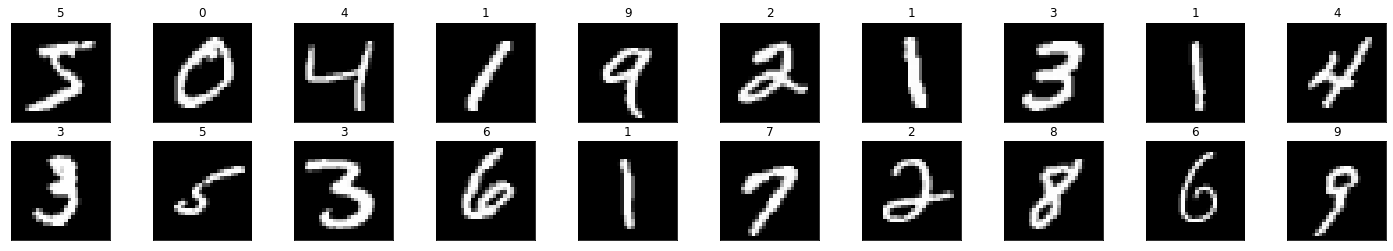

In [12]:
# 한 개의 배치에 있는 데이터 시각화
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [13]:
images.shape

(20, 1, 28, 28)

1 batch 당 20개의 이미지가 있고 1 x 28 x 28 형태로 구성되어 있음(입력 데이터)

### View an Image in More Detail

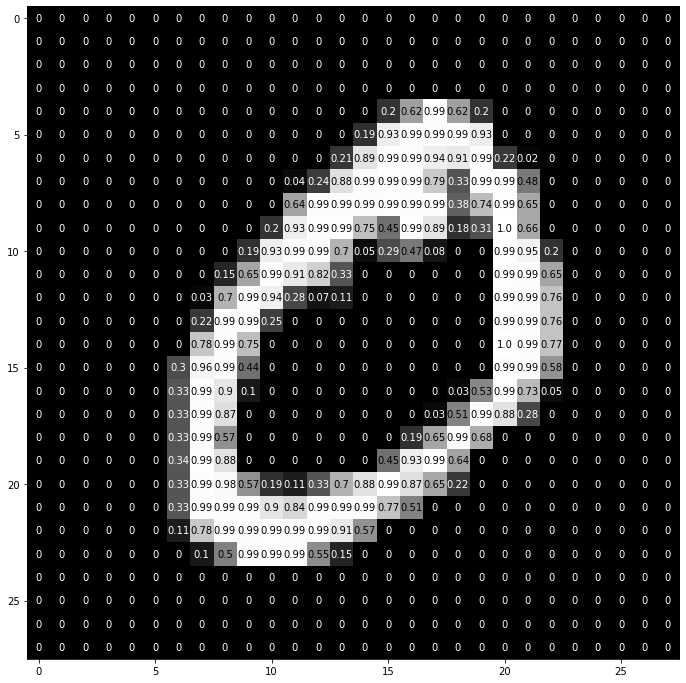

In [24]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [25]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        # linear layer (n_hidden -> 10)
        self.fc2 = nn.Linear(512, 10)


    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # return x
        return self.fc2(x)

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


Linear모델에 대해 설명하면<br>
입력 벡터 $\mathbf{x}$, 출력 벡터 $\mathbf{y}$, 가중치 행렬 $W$, 절편 $b$에 대해서<br>
$\mathbf{y} = \mathbf{x}W^T + b$에서 나타나지는 $W^T$와 $b$를 경사하강법으로 학습을 통해 구해내는 모델<br>
<br>
fc1 기준 $\mathbf{x}$ 차원은 20 x 784, $W^T$ 차원은 784 x 512, $b$ 차원은 20 x 512 따라서 $\mathbf{y}$의 차원은 20 x 512<br>
fc2 기준 $\mathbf{x}$ 차원은 20 x 512, $W^T$ 차원은 512 x 10, $b$ 차원은 20 x 10 따라서 $\mathbf{y}$의 차원은 20 x 10<br>

fc1에서는 28 x 28의 입력데이터를 512개의 출력으로 변환<br>
최초에 Net class의 forward 함수의 return 값은 x<br>
이 때 테스트 데이터에 대한 정확도는 91%<br>

<br>
이 경우 output이 512개가 되면서 512개의 값으로 0 ~ 9까지의 값을 예측해야 함<br>
물론 여러 번 반복 학습을 통해 그 값이 0 ~ 9까지의 값들로 예측을 하겠지만<br>
매우매우 아주 희박한 확률로 10이상의 값을 예측할 수 있음.<br>
또한 502개의 확률이 sparse한 값을 보이긴 하겠지만 군데군데 작은 값들이 채워지게 되면 결국 0 ~ 9까지의 예측확률이 100%가 아니게 됨<br>
<br>

---

### multilayer perceptron 성능 향상 방법 제안1

그러나 위에서 구현한 fc2를 살펴보면 fc2에서는 512개의 입력데이터를 10개의 출력으로 변환<br>
따라서 이전 layer에서 512개의 출력을 다시 입력으로 받아서 10개의 최종 출력으로 반환<br>
즉, 최종 출력을 분류 클래스의 개수와 일치 시켜줌

### multilayer perceptron 성능 향상 방법 제안2
학습률을 0.1에서 0.001로 낮춰서 그레디언트 변화폭을 줄여 더 정교하게 가중치와 절편을 찾도록 함


10000개의 테스트 데이터 중 170개를 제외하고 타깃 값이 일치하는것을 볼수 있음

### multilayer perceptron 성능 향상 방법 제안3
CNN으로 구현

In [33]:
## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # 특징 추출 부분
        self.features = nn.Sequential(
            # Conv1
            # 입력 채널: 1, 출력 채널: 32, 커널 크기: 3 x 3, 보폭: 1, 패딩 1
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            # 연산 결과를 기존 데이터에 반영
            nn.ReLU(inplace=True),
            # Max Pool1
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Conv2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # Max Pool2
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Conv3
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            # Conv4
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            # Max Pool3
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        # 분류 부분
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        self.classifier = nn.Sequential(
            # 드롭 아웃
            nn.Dropout(),
            # 완전 연결층 생성(입력 차원: 256 * 4 * 4, 출력 차원: 4096)
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            # 출력할 때에는 클래스 개수를 맞춰줘야 함
            nn.Linear(4096, 10),
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # 특징 추출 부분
        # 입력 이미지 x에 대해 추출된 특징이 x에 저장
        x = self.features(x)
        x = self.avgpool(x)
        # 격자 모양의 값들을 한 줄로 나열
        x = torch.flatten(x, 1)
        
        # 분류 부분
        x = self.classifier(x)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(4, 4))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=4096, out_features=10

---

###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

In [34]:
## Specify loss and optimization functions

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss


In [36]:
# number of epochs to train the model
n_epochs = 20  # suggest training between 10-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.577824
Epoch: 2 	Training Loss: 0.095824
Epoch: 3 	Training Loss: 0.065193
Epoch: 4 	Training Loss: 0.050126
Epoch: 5 	Training Loss: 0.040543
Epoch: 6 	Training Loss: 0.035795
Epoch: 7 	Training Loss: 0.030600
Epoch: 8 	Training Loss: 0.027014
Epoch: 9 	Training Loss: 0.023928
Epoch: 10 	Training Loss: 0.020246
Epoch: 11 	Training Loss: 0.018455
Epoch: 12 	Training Loss: 0.017904
Epoch: 13 	Training Loss: 0.015761
Epoch: 14 	Training Loss: 0.014688
Epoch: 15 	Training Loss: 0.012731
Epoch: 16 	Training Loss: 0.011668
Epoch: 17 	Training Loss: 0.011167
Epoch: 18 	Training Loss: 0.010312
Epoch: 19 	Training Loss: 0.009701
Epoch: 20 	Training Loss: 0.009298


---
## Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

#### `model.eval()`

`model.eval(`) will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

In [37]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

wrong_list = []

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.020331

Test Accuracy of     0: 99% (977/980)
Test Accuracy of     1: 99% (1134/1135)
Test Accuracy of     2: 99% (1027/1032)
Test Accuracy of     3: 99% (1005/1010)
Test Accuracy of     4: 100% (982/982)
Test Accuracy of     5: 99% (888/892)
Test Accuracy of     6: 98% (947/958)
Test Accuracy of     7: 98% (1017/1028)
Test Accuracy of     8: 99% (968/974)
Test Accuracy of     9: 98% (993/1009)

Test Accuracy (Overall): 99% (9938/10000)


### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

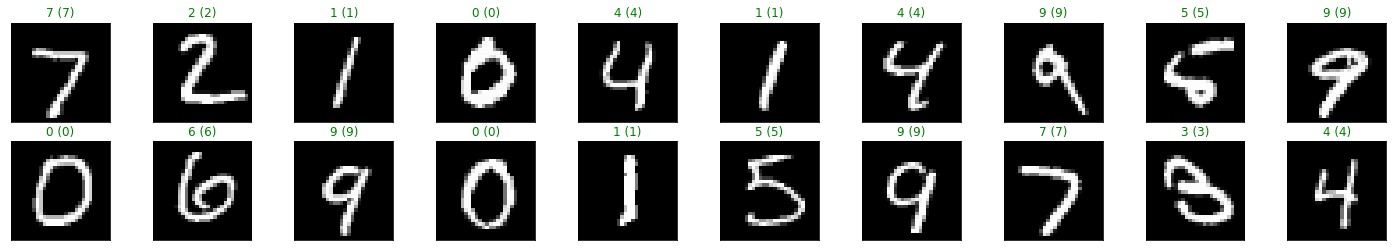

In [38]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

### TensorFlow로 코드변환

In [16]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

In [17]:
mnist_data = keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist_data.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [18]:
train_images.shape

(60000, 28, 28)

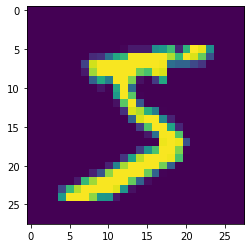

In [19]:
plt.figure()
plt.imshow(train_images[0])
plt.show()

In [26]:
train_labels[:20]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9],
      dtype=uint8)

In [28]:
# 정규화
train_images = train_images / 255.0
test_images = test_images / 255.0

In [ ]:
train_images[1]

In [83]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28,28)),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dense(10, activation = 'softmax')                      
])
print(model)

In [84]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_10 (Dense)            (None, 512)               401920    
                                                                 
 dense_11 (Dense)            (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


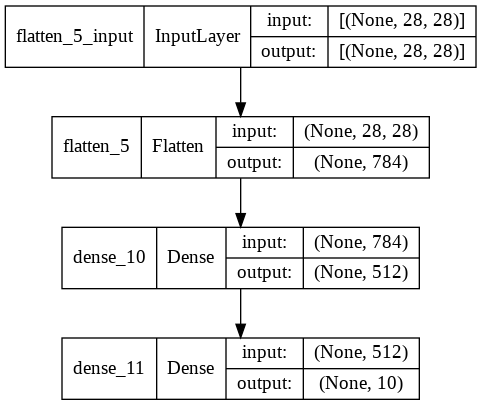

In [85]:
keras.utils.plot_model(model, show_shapes = True)

In [86]:
## Specify loss and optimization functions

opt = keras.optimizers.SGD(lr = 0.01)#(learning_rate=0.01)
model.compile(optimizer=opt,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [87]:
train_images.shape

(60000, 28, 28)

In [90]:
# number of epochs to train the model
n_epochs = 20  # suggest training between 10-50 epochs

model.fit(train_images, train_labels, epochs = n_epochs) 

Epoch 1/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1396 - accuracy: 0.9614
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1316 - accuracy: 0.9636
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1247 - accuracy: 0.9662
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1184 - accuracy: 0.9678
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1126 - accuracy: 0.9694
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1072 - accuracy: 0.9709
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1025 - accuracy: 0.9721
Epoch 8/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0980 - accuracy: 0.9738
Epoch 9/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0941 - accuracy: 0.9747
Epoch 10/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.090

In [91]:
model.evaluate(test_images, test_labels, verbose = 2)

313/313 - 1s - loss: 0.0822 - accuracy: 0.9755 - 729ms/epoch - 2ms/step


[0.08216140419244766, 0.9754999876022339]

선형 분류를 할 때에는 97.5%의 정확도를 보임

### CNN 구현

In [104]:
## Define the NN architecture

tf_cnn_model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same', input_shape = (28, 28, 1)),
    keras.layers.MaxPooling2D((3, 3), strides = (2, 2)),
    
    keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    keras.layers.MaxPooling2D((3, 3), strides = (2, 2)),

    keras.layers.Conv2D(192, (3, 3), activation = 'relu', padding = 'same'),
    
    keras.layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same'),

    keras.layers.MaxPooling2D((3, 3), strides = (2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(4096, activation = 'relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation = 'softmax')
])
print(tf_cnn_model)

In [105]:
tf_cnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 6, 6, 192)         110784    
                                                                 
 conv2d_23 (Conv2D)          (None, 6, 6, 256)       

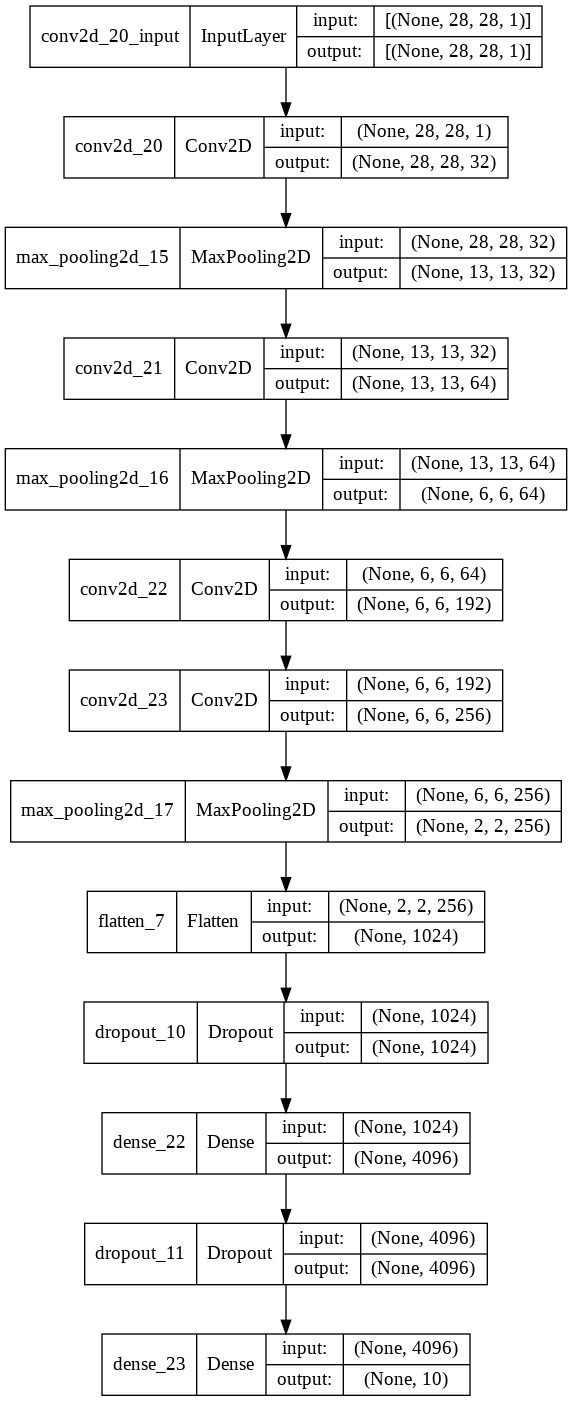

In [106]:
keras.utils.plot_model(tf_cnn_model, show_shapes = True)

In [107]:
opt = keras.optimizers.SGD(lr = 0.01)#(learning_rate=0.01)
tf_cnn_model.compile(optimizer=opt,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [111]:
tf_cnn_model.fit(train_images,train_labels, epochs = 20)

Epoch 1/20
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0258 - accuracy: 0.9920
Epoch 2/20
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0226 - accuracy: 0.9933
Epoch 3/20
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0214 - accuracy: 0.9934
Epoch 4/20
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0200 - accuracy: 0.9936
Epoch 5/20
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0180 - accuracy: 0.9945
Epoch 6/20
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0175 - accuracy: 0.9944
Epoch 7/20
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0164 - accuracy: 0.9948
Epoch 8/20
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0156 - accuracy: 0.9953
Epoch 9/20
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0160 - accuracy: 0.9946
Epoch 10/20
1875/1875 [==============================] - 21s 11m

In [114]:
tf_cnn_model.evaluate(test_images, test_labels, verbose = 2)

313/313 - 2s - loss: 0.0334 - accuracy: 0.9896 - 2s/epoch - 8ms/step


[0.03336696699261665, 0.9896000027656555]

tensorflow로 구현했을 시 대략 99% 정확도를 보임